# Explicabilidad (XAI)

**Enfoque Multi-Método**

Este notebook implementa un **enfoque de caja de herramientas** para la explicabilidad, combinando múltiples métodos complementarios:

| Método | Tipo | Alcance | Fortaleza principal |
|--------|------|---------|---------------------|
| **Importancia Nativa** | Model-specific | Global | Rápido, integrado |
| **Permutation Importance** | Model-agnostic | Global | Sin sesgo cardinalidad [2] |
| **SHAP** | Model-agnostic | Global + Local | Fundamento teórico [3] |
| **PDP/ICE** | Model-agnostic | Global | Efectos marginales [4] |
| **LIME** | Model-agnostic | Local | Aproximación lineal [5] |
| **DiCE** | Model-agnostic | Local | Contrafácticos [6] |

## Configuración del entorno

En esta sección prentendo dejar el entorno configurado para trabajar posteriormente.

Cargo las librerías a usar y  realizo configuraciones generales.

In [1]:
# Instalación de dependencias
# !pip install shap lime dice-ml catboost --quiet

In [2]:
# Bibliotecas estándar
import numpy as np
import pandas as pd
import os
import json
import joblib
import glob
import warnings
import time
from datetime import datetime
from typing import Dict, List, Any

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import catboost
from catboost import Pool

# XAI
import shap
import lime
import lime.lime_tabular
import dice_ml

# Google Colab (descomentar si se usa en Colab)
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Realizo configuraciones globales
warnings.filterwarnings('ignore')

Defino variables globales.

In [4]:
# Configuro la semilla para reproducibilidad, requisito fundamental según TRIPOD-AI (ítem 14) [TRIPOD] y el AI Act [AI Act] para sistemas de alto riesgo
RANDOM_STATE = 1976

# Defino las rutas a los ficheros
# Configuro la ruta de los datos.
DRIVE_PATH = 'D:\\Desarrollo\\TFG\\Procesado\\' # Local
# DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/TFG/Dataset/Procesado/' # Google Drive

# Configuro las rutas para guardar modelos y resultados
MODELS_PATH = os.path.join(DRIVE_PATH, 'modelos')
RESULTS_PATH = os.path.join(DRIVE_PATH, 'resultados')
FIGURES_PATH = os.path.join(DRIVE_PATH, 'figuras')
XAI_PATH = os.path.join(RESULTS_PATH, 'xai')

for path in [MODELS_PATH, RESULTS_PATH, FIGURES_PATH, XAI_PATH]:
    os.makedirs(path, exist_ok=True)

# Defino los ficheros de datos
X_TRAIN_FILE = os.path.join(DRIVE_PATH, 'X_train_selected.csv')
X_VAL_FILE = os.path.join(DRIVE_PATH, 'X_val_selected.csv')
X_TEST_FILE = os.path.join(DRIVE_PATH, 'X_test_selected.csv')
Y_TRAIN_FILE = os.path.join(DRIVE_PATH, 'y_train.csv')
Y_VAL_FILE = os.path.join(DRIVE_PATH, 'y_val.csv')
Y_TEST_FILE = os.path.join(DRIVE_PATH, 'y_test.csv')
ENCODERS_FILE = os.path.join(DRIVE_PATH, 'encoders_mapping.json')

Creo una función para mostrar logs

In [5]:
def log(mensaje):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {mensaje}")

### Carga de datos y modelo

Se cargan desde disco el modelo para trabajar con él.

In [6]:
# Cargo los datos
X_train = pd.read_csv(X_TRAIN_FILE)
X_val = pd.read_csv(X_VAL_FILE)
X_test = pd.read_csv(X_TEST_FILE)
y_train = pd.read_csv(Y_TRAIN_FILE).squeeze()
y_val = pd.read_csv(Y_VAL_FILE).squeeze()
y_test = pd.read_csv(Y_TEST_FILE).squeeze()

with open(ENCODERS_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)
CLASS_NAMES = {int(k): v for k, v in data['cardiopatia'].items()
                if v != 'No se puede determinar'}
RACE_ETHNICITY = {int(k): v for k, v in data['race_ethnicity'].items()}

TARGET_LABEL_NAME = "Estenosis"
TARGET_CLASS_IDX = next(k for k, v in CLASS_NAMES.items() if v == TARGET_LABEL_NAME)
TARGET_SAFE_CLASS_NAME = 'Ninguna'
SAFE_CLASS_IDX = next(k for k, v in CLASS_NAMES.items() if v == TARGET_SAFE_CLASS_NAME)

# Defino constantes globales
N_CLASSES = len(CLASS_NAMES)
FEATURE_NAMES = X_train.columns.tolist()

# Defino las variables categóricas, aunque sean codificadas como números
CATEGORICAL_FEATURES = ['sex_encoded', 'race_ethnicity_encoded']
CATEGORICAL_INDEXES = [FEATURE_NAMES.index(col) for col in CATEGORICAL_FEATURES if col in FEATURE_NAMES]

In [7]:
# Cargo el modelo final
SELECTED_MODEL = 'catboost'
FINAL_MODEL_PATH = os.path.join(MODELS_PATH, f'{SELECTED_MODEL}_*.joblib')
model_files = glob.glob(os.path.join(MODELS_PATH, f'{SELECTED_MODEL}_*.joblib'))
if not model_files:
    raise FileNotFoundError(f"No se encontró el modelo final {FINAL_MODEL_PATH}.")

model_files.sort(reverse=True)
model_file = model_files[0]
meta_file = model_file.replace('.joblib', '_meta.json')

FINAL_MODEL = joblib.load(model_file)

print(f'MODELO PARA ANÁLISIS XAI')
print(f'Tipo: {type(FINAL_MODEL).__name__}')
print(f'Features: {len(FEATURE_NAMES)}')
print(f'Clases: {N_CLASSES} ({", ".join(CLASS_NAMES.values())})')

MODELO PARA ANÁLISIS XAI
Tipo: CatBoostClassifier
Features: 48
Clases: 4 (Ambas, Estenosis, Insuficiencia, Ninguna)


## Importancia nativa (Baseline)
**Definición Técnica**: Es un método específico para modelos basados en árboles (como Random Forest o XGBoost). Calcula la importancia de una característica sumando la reducción de impureza (Gini o Entropía) que aporta dicha variable cada vez que es seleccionada para hacer una división (split) en cualquiera de los árboles del ensamble.

**Justificación de uso**: Se utiliza como línea base (baseline) por su coste computacional nulo (se calcula durante el entrenamiento). Sin embargo, se toma con cautela debido a su conocido sesgo a favor de variables con alta cardinalidad (variables numéricas con muchos valores únicos).

**Tipo de explicación**
| Propiedad | Valor |
|-----------|-------|
| **Alcance** | Global |
| **Tipo** | Model-specific (solo árboles) |
| **Método** | Mean Decrease in Impurity (MDI) |
| **Dirección** | No indica si aumenta o disminuye la predicción |
| **Velocidad** | Muy rápida (precalculada) |

In [8]:
# Realizo el análisis de importancia de características nativo del modelo
if hasattr(FINAL_MODEL, 'feature_importances_'):
    df_native = pd.DataFrame({
        'Feature': FEATURE_NAMES,
        'Importance': FINAL_MODEL.feature_importances_,
    }).sort_values('Importance', ascending=False)
    df_native['Rank'] = range(1, len(df_native) + 1)
    df_native['Cumulative_%'] = df_native['Importance'].cumsum() / df_native['Importance'].sum() * 100

    # Guardo el resultado
    df_native.to_csv(os.path.join(XAI_PATH, 'native_importance.csv'), index=False)
else:
    print("El modelo no soporta importancia nativa (no es basado en árboles o es lineal sin coeficientes directos).")

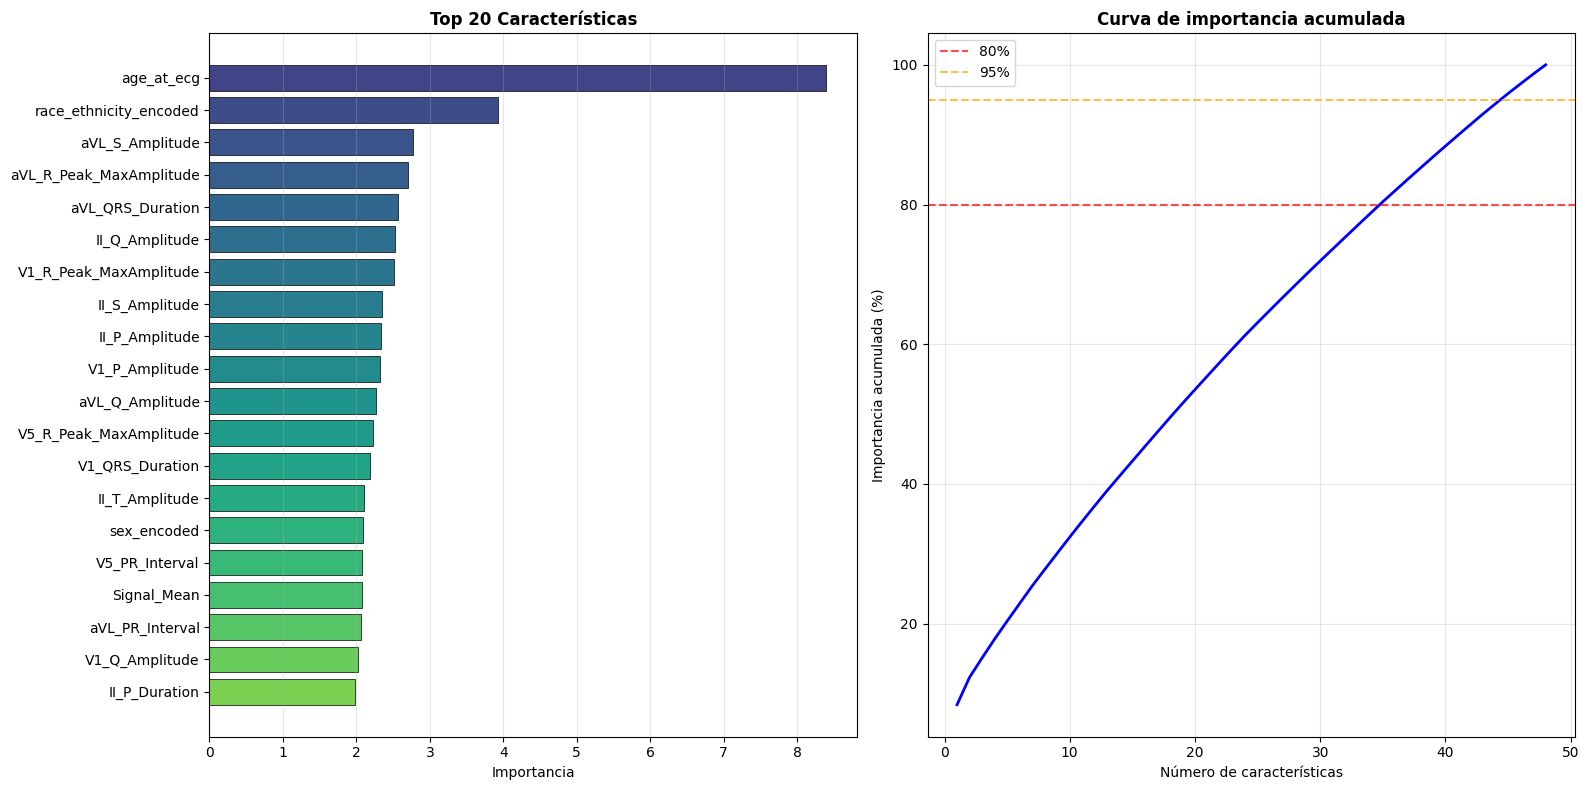

In [9]:
# Visualizo la importancia de características nativa del modelo
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Para las 20 características más importantes
ax1 = axes[0]
top_n = 20
top_features = df_native.head(top_n)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))

bars = ax1.barh(range(top_n), top_features['Importance'].values,
                color=colors, edgecolor='black', linewidth=0.5)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_features['Feature'].values)
ax1.invert_yaxis()
ax1.set_xlabel('Importancia')
ax1.set_title(f'Top {top_n} Características', fontweight='bold')
ax1.grid(True, axis='x', alpha=0.3)

# Curva acumulada
ax2 = axes[1]
ax2.plot(df_native['Rank'], df_native['Cumulative_%'], 'b-', lw=2)
ax2.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80%')
ax2.axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95%')
ax2.set_xlabel('Número de características')
ax2.set_ylabel('Importancia acumulada (%)')
ax2.set_title('Curva de importancia acumulada', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

## Permutation Feature Importance (PFI)
**Definición Técnica**: Es un método global y agnóstico al modelo introducido por Breiman (2001)[x][y]. Mide la dependencia del modelo respecto a una variable calculando el aumento en el error de predicción (o la caída en la métrica F1-Score) cuando los valores de esa característica se mezclan aleatoriamente (shuffling), rompiendo así la relación entre la variable y el objetivo.

**Justificación de uso**: Actúa como mecanismo de validación ("Sanity Check"). A diferencia de la importancia nativa, PFI se calcula sobre el conjunto de validación, lo que permite medir qué variables son importantes para la generalización y no solo para la memorización del entrenamiento.

**Tipo de explicación**
| Propiedad | Valor |
|-----------|-------|
| **Alcance** | Global |
| **Tipo** | Model-agnostic (sirve para cualquier modelo) |
| **Método** | Mide la caída del rendimiento (F1-Score) al "romper" una variable |
| **Robustez** | Alta (evita el sesgo de cardinalidad) |
| **Velocidad** | Lenta (requiere N re-evaluaciones) |

In [10]:
# Configuro el experimento PFI
# Uso F1-Macro porque es tu métrica de optimización principal
METRIC = 'f1_macro'
N_REPEATS = 10

# Realizo el cálculo
start_time = time.time()
pfi_result = permutation_importance(
    FINAL_MODEL, X_val, y_val,
    n_repeats=N_REPEATS,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring=METRIC
)
elapsed_time = time.time() - start_time
log(f"PFI completado en {elapsed_time:.1f} segundos.")

# Creo un dataFrame ordenado
df_pfi = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Importance_Mean': pfi_result.importances_mean,
    'Importance_Std': pfi_result.importances_std
}).sort_values('Importance_Mean', ascending=False).reset_index(drop=True)

df_pfi['Rank'] = range(1, len(df_pfi) + 1)

# Guardo los resultados
csv_path = os.path.join(XAI_PATH, 'permutation_importance_global.csv')
df_pfi.to_csv(csv_path, index=False)

[2026-01-11 15:21:37] PFI completado en 3.8 segundos.


15 CARACTERÍSTICAS MÁS IMPORTANTES - PFI (F1_MACRO)
               Feature  Importance_Mean  Importance_Std  Rank
            age_at_ecg         0.051263        0.006413     1
        V1_PR_Interval         0.004020        0.004162     2
      aVL_QT_Corrected         0.003318        0.006179     3
        V5_T_Amplitude         0.003299        0.003883     4
        II_Q_Amplitude         0.003212        0.005258     5
      aVL_QRS_Duration         0.003163        0.003714     6
       aVL_Q_Amplitude         0.002836        0.001571     7
       aVL_T_Amplitude         0.002833        0.003002     8
        V1_T_Amplitude         0.002612        0.004988     9
           sex_encoded         0.001629        0.004711    10
        V1_S_Amplitude         0.001478        0.003805    11
       V5_QRS_Duration         0.001378        0.003712    12
       aVL_S_Amplitude         0.001334        0.004198    13
           Signal_Mean         0.000873        0.004354    14
race_ethnicity_enc

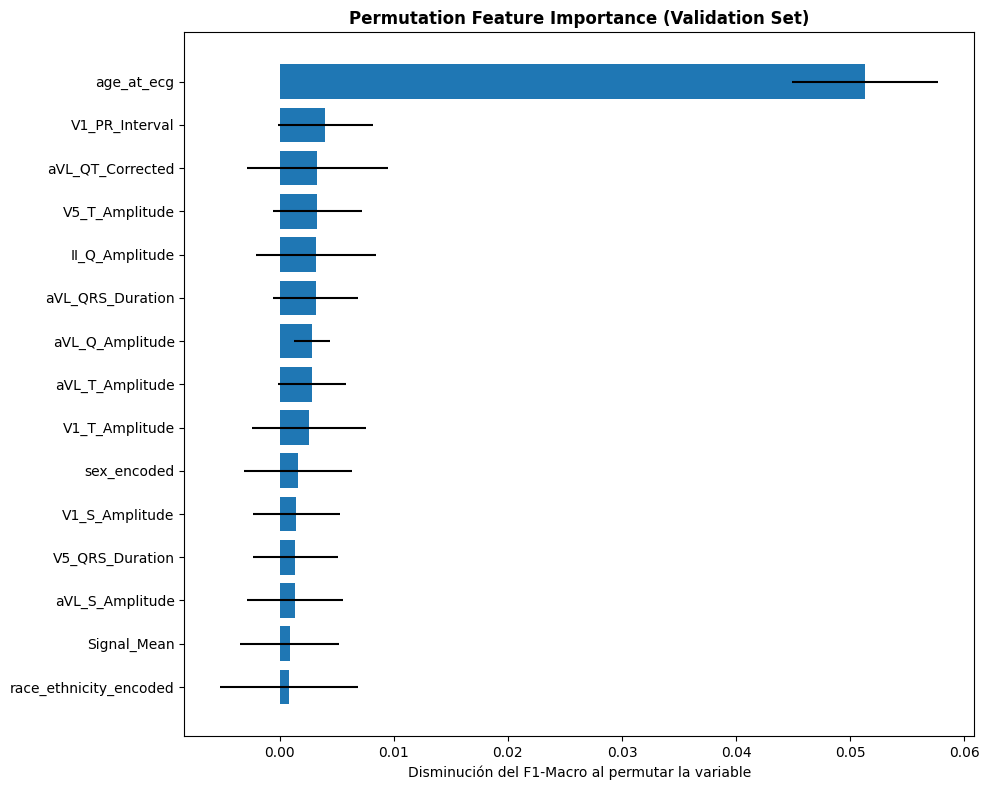

In [11]:
# Visualizo la importancia por permutación de las 15 principales características
print(f'15 CARACTERÍSTICAS MÁS IMPORTANTES - PFI ({METRIC.upper()})')
print(df_pfi.head(15).to_string(index=False))

plt.figure(figsize=(10, 8))
plt.barh(df_pfi.head(15)['Feature'], df_pfi.head(15)['Importance_Mean'], xerr=df_pfi.head(15)['Importance_Std'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance (Validation Set)", fontweight='bold')
plt.xlabel("Disminución del F1-Macro al permutar la variable")
plt.tight_layout()
plt.show()
plt.close()

## SHAP (SHapley Additive exPlanations) - Análisis Completo
**Definición Técnica**: Es un método fundamentado en la Teoría de Juegos Cooperativos (Lloyd Shapley, 1953)[]. Asigna a cada característica un "valor de Shapley", que representa su contribución marginal promedio a la predicción a través de todas las posibles coaliciones de características.

* **Propiedad Clave (Eficiencia Local)**: La suma de los valores SHAP de todas las características más el valor base (promedio) es exactamente igual a la predicción del modelo: $\sum \phi_i + E[f(x)] = f(x)$.

**Justificación de uso**:Es el estándar de oro (Gold Standard) actual en IA Explicable debido a sus garantías matemáticas de consistencia. Se utiliza TreeExplainer, una variante optimizada para árboles que captura interacciones no lineales exactas en tiempo polinómico.

**Tipo de explicación**
| Propiedad | Valor |
|-----------|-------|
| **Alcance** | Global (agregando explicaciones locales) |
| **Tipo** | Model-agnostic (TreeExplainer optimizado) |
| **Método** | Valores de Shapley (Teoría de Juegos) |
| **Dirección** | Sí (Rojo = Alto valor -> Impacto +/-) |
| **Interacciones** | Captura efectos complejos y no lineales |

**Interpretación:** * **Eje Y:** Variables ordenadas por importancia.
* **Eje X:** Impacto en la predicción (SHAP value).
* **Color:** Valor de la variable (Rojo = Alto, Azul = Bajo).
* *Ejemplo:* Si los puntos rojos están a la derecha, valores altos de esa variable aumentan el riesgo.

##**USO EL SHAP DE CATBOOST PUES EL GENÉRICO DABA UN CRASH DE KERNEL**

### Procesamiento para la explicación

In [12]:
# Preparo el dataset de background para SHAP
# El background dataset es la referencia para calcular valores SHAP.
# Usaré una muestra estratificada para eficiencia.

N_BACKGROUND = min(500, len(X_train))

if N_BACKGROUND < len(X_train):
    _, X_background, _, y_background = train_test_split(
        X_train, y_train,
        test_size=N_BACKGROUND,
        stratify=y_train,
        random_state=RANDOM_STATE
    )
else:
    X_background = X_train.copy()
    y_background = y_train.copy()

print(f'Distribución de clases en background:')
for class_id, class_name in CLASS_NAMES.items():
    n = (y_background == class_id).sum()
    print(f'{class_name}: {n} ({n/len(y_background)*100:.1f}%)')

Distribución de clases en background:
Ambas: 65 (13.0%)
Estenosis: 9 (1.8%)
Insuficiencia: 326 (65.2%)
Ninguna: 100 (20.0%)


In [13]:
# Calculo los valores SHAP para el conjunto de validación usando SHAP nativo de CATBoost.
log(f'Calculando valores SHAP para {len(X_val)} muestras...')
start_time = time.time()
pool_val = Pool(
    X_val,
    cat_features=CATEGORICAL_FEATURES
)
# raw shape contine: (samples, classes, features+1)
shap_raw = FINAL_MODEL.get_feature_importance(
    data=pool_val,
    type="ShapValues"
)
elapsed_time = time.time() - start_time
log(f'SHAP completado en {elapsed_time:.1f} segundos.')

print(f'Forma de SHAP values:')
n_samples, n_classes, n_cols = shap_raw.shape
n_features = n_cols - 1
print(f"Samples = {n_samples}, Clases = {n_classes}, Features = {n_features}")


[2026-01-11 15:21:37] Calculando valores SHAP para 2053 muestras...
[2026-01-11 15:21:39] SHAP completado en 1.3 segundos.
Forma de SHAP values:
Samples = 2053, Clases = 4, Features = 48


In [14]:
# Extraigo los valores esperados (base) por clase
expected_values = shap_raw[0, :, -1]

print("\nExpected values (valor base por clase):")
for class_id, class_name in CLASS_NAMES.items():
    print(f"{class_name}: {expected_values[class_id]:.4f}")


Expected values (valor base por clase):
Ambas: 0.1128
Estenosis: -1.0512
Insuficiencia: 0.6323
Ninguna: 0.3061


In [15]:
# Calculo la importancia global de características usando los valores SHAP
shap_importance = np.abs(shap_raw[:, :, :-1]).mean(axis=(0, 1)) # Promedio sobre muestras y clases

df_shap_importance = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False).reset_index(drop=True)

df_shap_importance['Rank'] = range(1, len(df_shap_importance) + 1)
df_shap_importance.to_csv(os.path.join(XAI_PATH, 'shap_importance_global.csv'), index=False)

print(f'15 CARACTERÍSTICAS MÁS IMPORTANTES - IMPORTANCIA SHAP GLOBAL')
print(df_shap_importance.head(15).to_string(index=False))

15 CARACTERÍSTICAS MÁS IMPORTANTES - IMPORTANCIA SHAP GLOBAL
                Feature  SHAP_Importance  Rank
             age_at_ecg         0.288113     1
         II_Q_Amplitude         0.095239     2
 race_ethnicity_encoded         0.093921     3
            sex_encoded         0.072838     4
         V1_P_Amplitude         0.064356     5
          V5_P_Duration         0.054998     6
 V1_R_Peak_MaxAmplitude         0.052608     7
aVL_R_Peak_MaxAmplitude         0.051055     8
        V1_QRS_Duration         0.050974     9
         V5_PR_Interval         0.050872    10
            Signal_Mean         0.049665    11
         II_P_Amplitude         0.043069    12
        aVL_T_Amplitude         0.042490    13
         V1_S_Amplitude         0.042216    14
             Signal_Std         0.040798    15


### Visualización de la explicación

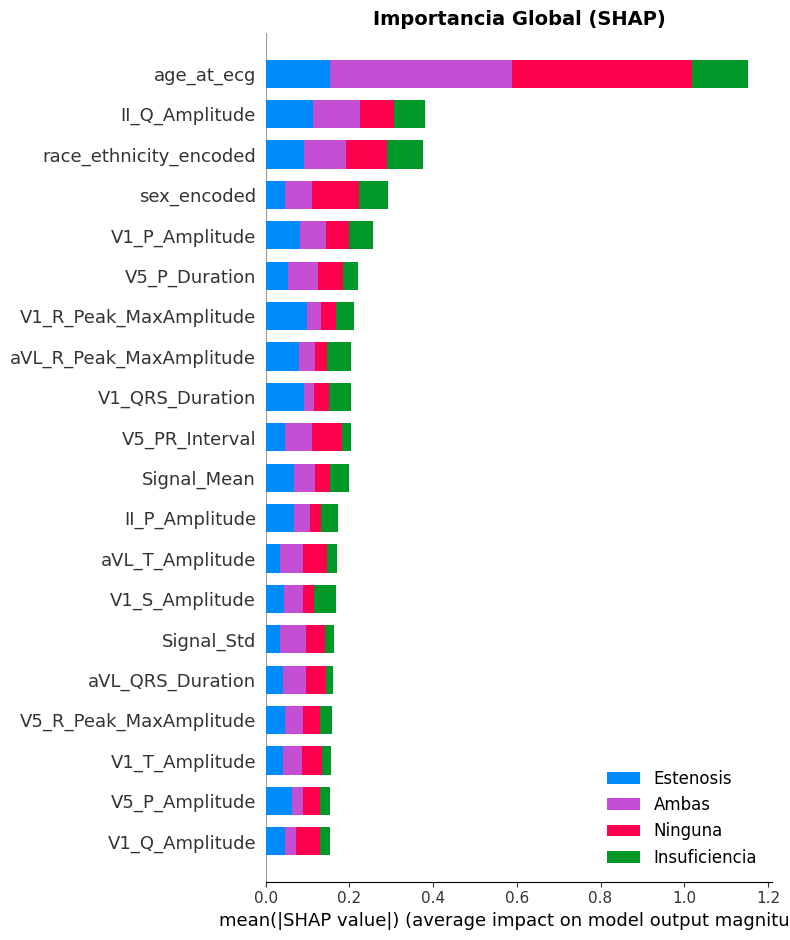

In [16]:
# Creo una gráfica de resumen SHAP (bar plot)
plt.figure(figsize=(12, 10))

shap_values_list = [shap_raw[:, c, :-1] for c in range(n_classes)]
shap.summary_plot(
    shap_values_list, X_val,
    feature_names=FEATURE_NAMES,
    plot_type='bar',
    class_names=list(CLASS_NAMES.values()),
    max_display=20,
    show=False
)

plt.title('Importancia Global (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

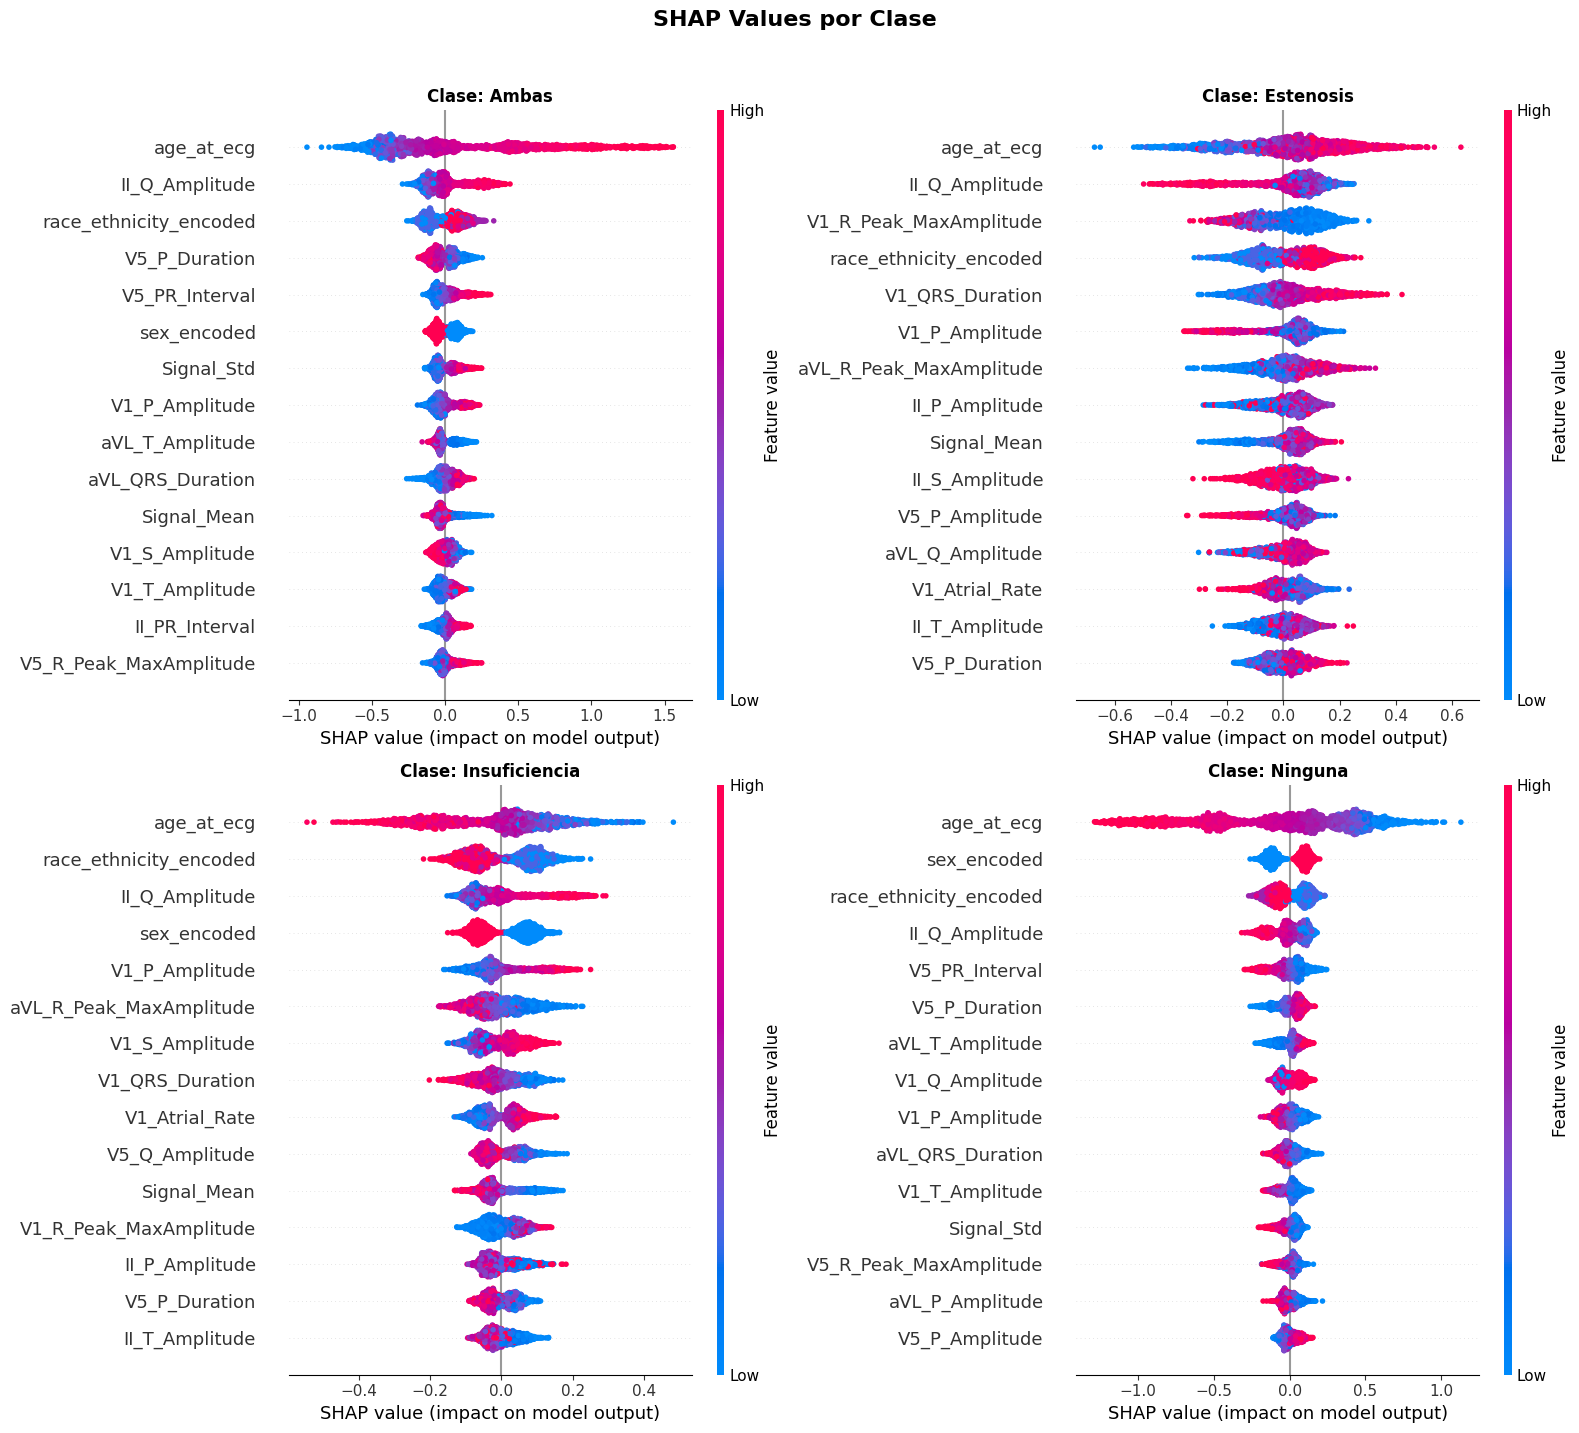

In [17]:
# Creo Beeswarm plots por clase para mostar cómo el valor de cada característica afecta la predicción.
# Color: valor de la característica (rojo=alto, azul=bajo)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, (class_id, class_name) in enumerate(CLASS_NAMES.items()):
    plt.sca(axes[i])
    shap.summary_plot(
        shap_raw[:, class_id, :-1],
        X_val,
        feature_names=FEATURE_NAMES,
        max_display=15,
        show=False,
        plot_size=None
    )
    axes[i].set_title(f'Clase: {class_name}', fontweight='bold')

plt.suptitle('SHAP Values por Clase', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

## Análisis de Comportamiento: PDP & ICE
**Definición Técnica**:
* PDP (Global): Muestra el efecto marginal promedio de una característica sobre el resultado predicho, marginalizando sobre los valores de todas las demás características. Aproxima la función: $\hat{f}_{x_S}(x_S) = E_{x_C}[\hat{f}(x_S, x_C)]$.

* ICE (Local): Desagrega el promedio del PDP, mostrando una curva funcional para cada instancia individual del dataset.

**Justificación de uso**: Mientras que SHAP indica "cuánto" importa una variable, PDP/ICE revelan "cómo" se comporta. Son esenciales en el ámbito médico para identificar umbrales de riesgo (p.ej., "¿El riesgo aumenta linealmente con la edad o se dispara exponencialmente a partir de los 60 años?") y detectar interacciones ocultas (cuando las líneas ICE divergen).

**Tipo de explicación**
| Propiedad | Valor |
|-----------|-------|
| **Alcance** | Global (PDP) + Individual (ICE) |
| **Método** | Efecto marginal manteniendo otras variables fijas |
| **Pregunta clínica** | "¿A partir de qué valor aumenta el riesgo?" |

**Interpretación:**
* **Línea Naranja (PDP):** El efecto promedio.
* **Líneas Azules (ICE):** El efecto para cada paciente individual.
* Si las líneas azules se cruzan o divergen, el efecto de esa variable depende de otras (interacción).

PDP & ICE completado en 1.3 segundos.


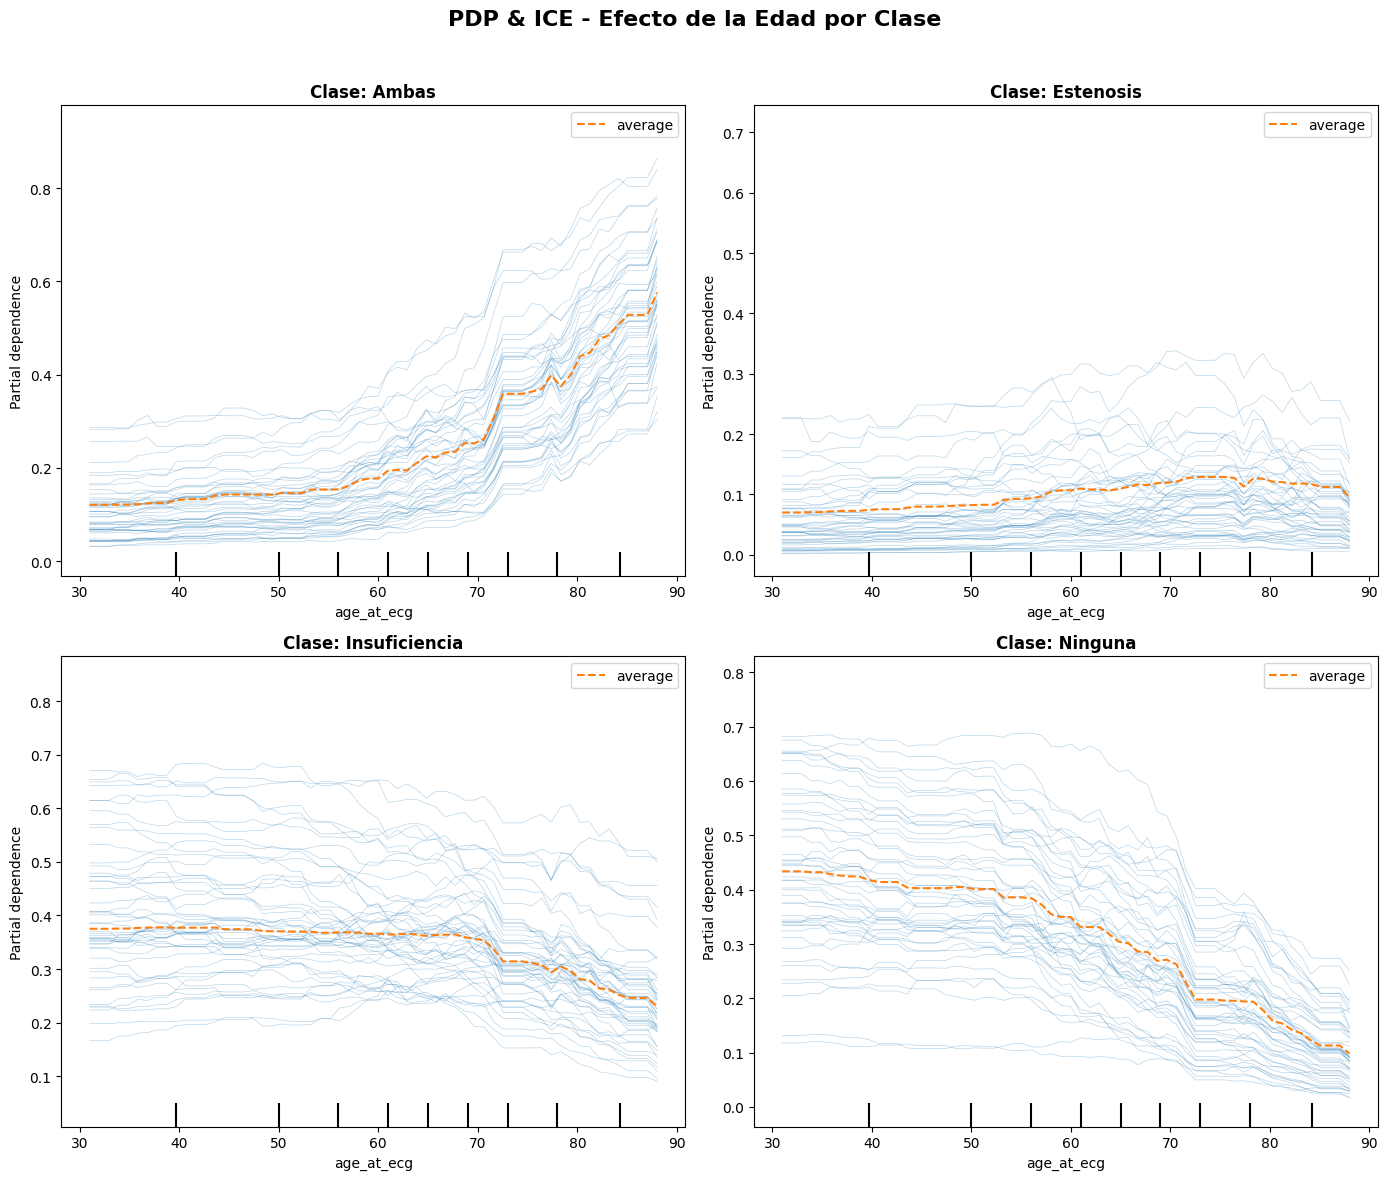

In [18]:
# PDP & ICE para edad por clase (2x2)
feature_edad = ['age_at_ecg']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes_flat = axes.flatten()

start_time = time.time()

for i, (class_id, class_name) in enumerate(CLASS_NAMES.items()):
    PartialDependenceDisplay.from_estimator(
        FINAL_MODEL,
        X_val,
        feature_edad,
        kind="both",
        target=class_id,
        subsample=50,
        n_jobs=-1,
        grid_resolution=60,
        ax=axes_flat[i]
    )
    axes_flat[i].set_xlabel('age_at_ecg', fontsize=10, fontweight='bold')
    axes_flat[i].set_title(f'Clase: {class_name}', fontsize=12, fontweight='bold')

elapsed_time = time.time() - start_time
print(f"PDP & ICE completado en {elapsed_time:.1f} segundos.")

plt.suptitle('PDP & ICE - Efecto de la Edad por Clase', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.close()

## SHAP - Explicaciones Locales

Las explicaciones locales muestran por qué el modelo realizó una predicción concreta.

Esto es fundamental para:
1. **Transparencia clínica**: El médico entiende qué influyó en la predicción.
2. **Validación caso a caso**: Verificar coherencia clínica.
3. **Cumplimiento del AI Act**: Artículo 14 requiere interpretabilidad [1].

En lugar de buscar un caso aleatorio, se busca sistemáticamente el "Caso Prototípico" (TP con mayor confianza) y el "Error Crítico" (FN) para cada clase, generando así un reporte visual estructurado.

ANÁLISIS LOCAL: FOCO EN ESTENOSIS
Acierto (TP) Índice: 1000 | Confianza: 56.72%
[2026-01-11 15:21:43] Waterfall de SHAP para TP completado en 0.0 segundos.


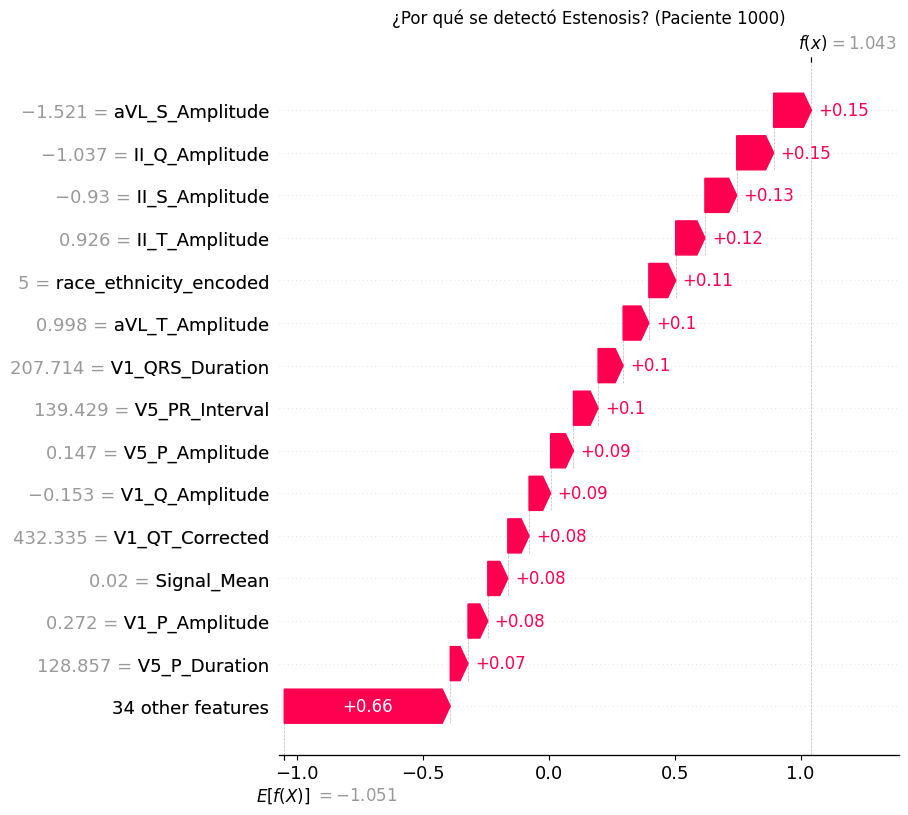

Error (FN) Índice: 48 | Predicho como: Ninguna
[2026-01-11 15:21:43] Waterfall de SHAP para FN completado en 0.0 segundos.


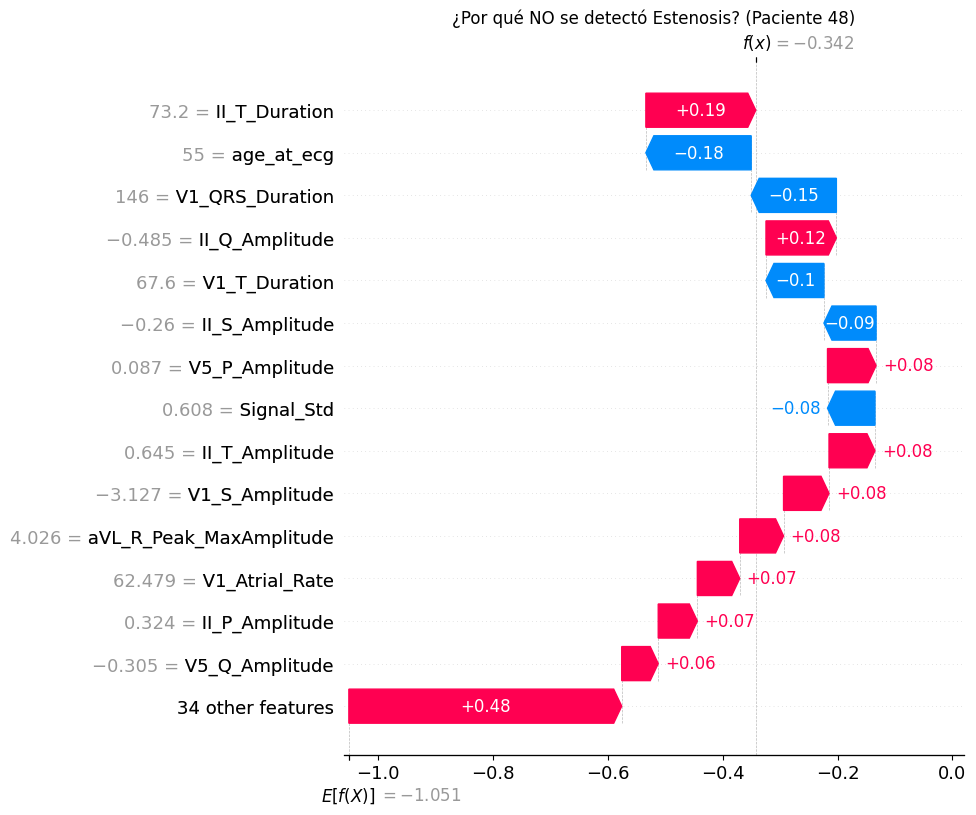

In [19]:
# Hago un precálculo de las predicciones
y_pred = FINAL_MODEL.predict(X_val).reshape(-1)
y_proba = FINAL_MODEL.predict_proba(X_val)

# Calculo los valores SHAP por muestra y por clase sin expected value: (samples, classes, features)
shap_sample = shap_raw[:, :, :-1]

# Hago un análisis específico para ESTENOSIS
print(f"ANÁLISIS LOCAL: FOCO EN {TARGET_LABEL_NAME.upper()}")

# Identifico un verdadero positivo
tp_indices = np.where((y_val == TARGET_CLASS_IDX) & (y_pred == TARGET_CLASS_IDX))[0]
if len(tp_indices) > 0:
    idx_case_tp = tp_indices[np.argmax(y_proba[tp_indices, TARGET_CLASS_IDX])]
    print(f"Acierto (TP) Índice: {idx_case_tp} | Confianza: {y_proba[idx_case_tp, TARGET_CLASS_IDX]:.2%}")

    # Preparo el waterfall
    start_time = time.time()
    shap_exp_tp = shap.Explanation(
        values = shap_sample[idx_case_tp, TARGET_CLASS_IDX, :],
        base_values = expected_values[TARGET_CLASS_IDX],
        data=X_val.iloc[idx_case_tp].values,
        feature_names=FEATURE_NAMES
    )
    elapsed_time = time.time() - start_time
    log(f"Waterfall de SHAP para TP completado en {elapsed_time:.1f} segundos.")

    plt.title(f"¿Por qué se detectó {TARGET_LABEL_NAME}? (Paciente {idx_case_tp})")
    shap.plots.waterfall(shap_exp_tp, max_display=15, show=True)
else:
    print("No hay aciertos para Estenosis en validación.")
    idx_case_tp = None

# Identifico un falso negativo (Error Crítico)
fn_indices = np.where((y_val == TARGET_CLASS_IDX) & (y_pred != TARGET_CLASS_IDX))[0]
if len(fn_indices) > 0:
    idx_case_fn = fn_indices[0] # El primero
    pred_class = CLASS_NAMES[y_pred[idx_case_fn]]
    print(f"Error (FN) Índice: {idx_case_fn} | Predicho como: {pred_class}")

    # Preparo el waterfall
    start_time = time.time()
    shap_exp_fn = shap.Explanation(
        values = shap_sample[idx_case_fn, TARGET_CLASS_IDX, :],
        base_values = expected_values[TARGET_CLASS_IDX],
        data=X_val.iloc[idx_case_fn].values,
        feature_names=FEATURE_NAMES
    )
    elapsed_time = time.time() - start_time
    log(f"Waterfall de SHAP para FN completado en {elapsed_time:.1f} segundos.")
    plt.title(f"¿Por qué NO se detectó {TARGET_LABEL_NAME}? (Paciente {idx_case_fn})")
    shap.plots.waterfall(shap_exp_fn, max_display=15, show=True)
else:
    print("No hay Falsos Negativos para Estenosis en validación.")
    idx_case_fn = None

## LIME
**Definición Técnica**: LIME asume que cualquier modelo complejo es linealmente aproximable en una vecindad muy pequeña. Para explicar una predicción individual, genera datos sintéticos alrededor de esa instancia, obtiene sus predicciones con el modelo complejo y ajusta un modelo lineal simple ponderado (LASSO o Ridge) que actúa como modelo subrogado local.

**Justificación de uso**: Se emplea como herramienta de contrastación. Su salida (coeficientes lineales) es a menudo más intuitiva para el personal clínico que los valores aditivos de Shapley. Si LIME y SHAP coinciden en los factores de riesgo para un paciente, aumenta la robustez de la explicación.

**Tipo de explicación**
| Propiedad | Valor |
|-----------|-------|
| **Alcance** | Local |
| **Método** | Modelo lineal subrogado local |
| **Utilidad** | Validación cruzada de la explicación SHAP y simplicidad comunicativa |

**Interpretación:** Muestra qué variables empujan hacia una clase u otra basándose en una aproximación lineal local ($y = ax + b$).

In [20]:
# Defino la función de predicción adaptada para LIME
def wrapper_predict(x_numpy):
        # Reconstruyo el dataFrame (LIME pasa numpy, CatBoost requiere Pandas con columnas)
        df = pd.DataFrame(x_numpy, columns=FEATURE_NAMES)

        # Adapto los tipos (LIME usa floats, CatBoost requiere ints para categóricas)
        for col in CATEGORICAL_FEATURES:
            df[col] = df[col].fillna(0).astype(int)

        return FINAL_MODEL.predict_proba(df)

VALIDACIÓN CRUZADA CON LIME (Paciente 1000)
[2026-01-11 15:21:58] LIME para TP completado en 0.1 segundos.


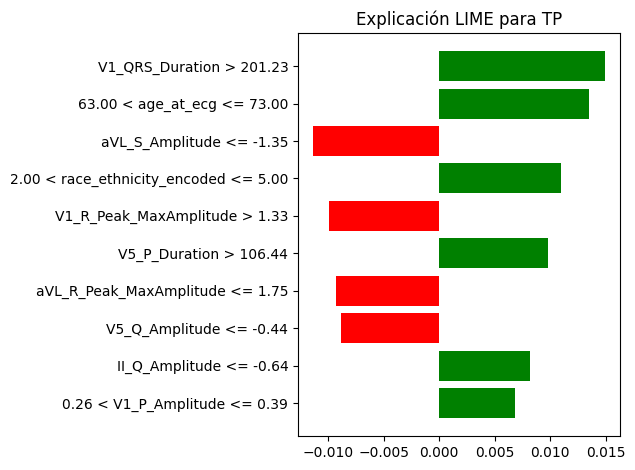

                  Variable  Valor_Paciente  Peso_LIME
0          V1_QRS_Duration      207.714286   0.014984
1               age_at_ecg       70.000000   0.013548
2          aVL_S_Amplitude       -1.521318  -0.011387
3   race_ethnicity_encoded        5.000000   0.010963
4   V1_R_Peak_MaxAmplitude        2.326204  -0.009962
5            V5_P_Duration      128.857143   0.009849
6  aVL_R_Peak_MaxAmplitude        0.649183  -0.009256
7           V5_Q_Amplitude       -0.582331  -0.008849
8           II_Q_Amplitude       -1.037207   0.008163
9           V1_P_Amplitude        0.272285   0.006812


In [22]:
# Análisis con LIME para el mismo TP usado en SHAP
if idx_case_tp is not None:
    print(f"VALIDACIÓN CRUZADA CON LIME (Paciente {idx_case_tp})")

    # Inicializo explainer LIME
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=FEATURE_NAMES,
        class_names=list(CLASS_NAMES.values()),
        mode='classification',
        random_state=RANDOM_STATE
    )

    # Realizo la explicación
    start_time = time.time()
    exp_lime = lime_explainer.explain_instance(
        data_row=X_val.iloc[idx_case_tp],
        predict_fn=wrapper_predict,
        num_features=10,
        top_labels=1
    )
    elapsed_time = time.time() - start_time
    log(f"LIME para TP completado en {elapsed_time:.1f} segundos.")

    # Muestro la explicación como figura matplotlib
    fig = exp_lime.as_pyplot_figure()
    plt.title(f"Explicación LIME para TP")
    plt.tight_layout()
    plt.show()
    plt.close()

    # Extraigo los datos de la explicación LIME
    data_extract = []
    for feature_idx, weight in exp_lime.as_map()[1]:
        col_name = FEATURE_NAMES[feature_idx]
        original_value = X_val.iloc[idx_case_tp].iloc[feature_idx]
        data_extract.append({
            'Variable': col_name,
            'Valor_Paciente': original_value,
            'Peso_LIME': weight
        })

    df_results_lime = pd.DataFrame(data_extract)

    # Mostramos el resultado
    print(df_results_lime)
else:
    print("No hay aciertos para Estenosis en validación.")
    idx_case_tp = None

VALIDACIÓN CRUZADA CON LIME (Paciente 48)
[2026-01-11 15:58:06] LIME para FN completado en 0.1 segundos.


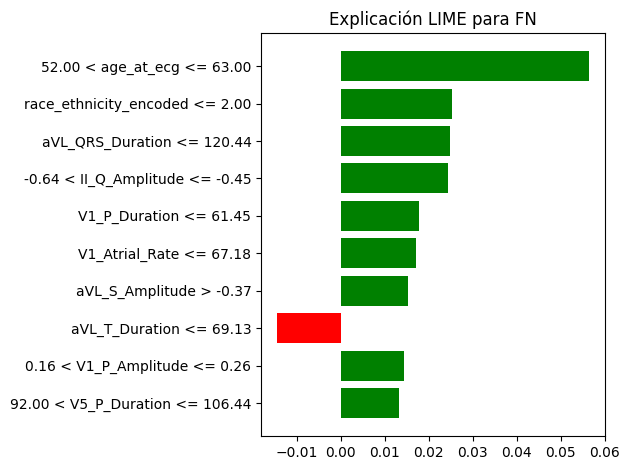

                 Variable  Valor_Paciente  Peso_LIME
0              age_at_ecg       55.000000   0.056511
1  race_ethnicity_encoded        2.000000   0.025259
2        aVL_QRS_Duration      112.400000   0.024736
3          II_Q_Amplitude       -0.484737   0.024286
4           V1_P_Duration       42.800000   0.017856
5          V1_Atrial_Rate       62.479108   0.017165
6         aVL_S_Amplitude       -0.324244   0.015362
7          aVL_T_Duration       58.400000  -0.014549
8          V1_P_Amplitude        0.205925   0.014445
9           V5_P_Duration      100.000000   0.013309


In [26]:
# Análisis con LIME para el mismo FN usado en SHAP
if idx_case_fn is not None:
    print(f"VALIDACIÓN CRUZADA CON LIME (Paciente {idx_case_fn})")

    # Inicializo explainer LIME
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=FEATURE_NAMES,
        class_names=list(CLASS_NAMES.values()),
        mode='classification',
        random_state=RANDOM_STATE
    )

    # Realizo la explicación
    start_time = time.time()
    exp_lime = lime_explainer.explain_instance(
        data_row=X_val.iloc[idx_case_fn],
        predict_fn=wrapper_predict,
        num_features=10,
        top_labels=1
    )
    elapsed_time = time.time() - start_time
    log(f"LIME para FN completado en {elapsed_time:.1f} segundos.")

    # Muestro la explicación como figura matplotlib
    chosen_label = exp_lime.available_labels()[0]
    fig = exp_lime.as_pyplot_figure(label=chosen_label)
    plt.title(f"Explicación LIME para FN")
    plt.tight_layout()
    plt.show()
    plt.close()

    # Extraigo los datos de la explicación LIME
    data_extract = []
    label = exp_lime.available_labels()[0]
    for feature_idx, weight in exp_lime.as_map()[label]:
        col_name = FEATURE_NAMES[feature_idx]
        original_value = X_val.iloc[idx_case_fn].iloc[feature_idx]
        data_extract.append({
            'Variable': col_name,
            'Valor_Paciente': original_value,
            'Peso_LIME': weight
        })

    df_results_lime = pd.DataFrame(data_extract)

    # Mostramos el resultado
    print(df_results_lime)
else:
    print("No hay fallos para Estenosis en validación.")
    idx_case_tp = None

## DiCE: Análisis Contrafactual
**Definición Técnica**: DiCE (Diverse Counterfactual Explanations) formula la explicabilidad como un problema de optimización. Busca encontrar el cambio mínimo necesario en el vector de características de entrada $x$ para que la función de decisión del modelo $f(x)$ cambie su clasificación (ej. de "Sano" a "Estenosis").

**Justificación de uso**: Aporta accionabilidad (Actionability). Transforma la explicación de descriptiva ("Usted tiene riesgo por X") a prescriptiva ("Si X bajara al valor Y, el riesgo desaparecería"). Es fundamental para la medicina personalizada, aunque siempre sujeto a la validación por parte del personal sanitario.

**Tipo de explicación**
| Propiedad | Valor |
|-----------|-------|
| **Alcance** | Local |
| **Método** | Búsqueda de cambios mínimos para invertir la predicción |
| **Accionabilidad** | Responde "¿Qué hacer?" |

**Pregunta Clínica:** ¿Qué parámetros tendría que cambiar este paciente para que el modelo lo clasificara como "Estenosis")?

**Advertencia:** Los cambios son matemáticos. Una persona especialista en médicina debe validar el resultado.

In [ ]:
# Creo una clase wrapper para adaptar CatBoost a DiCE
class ModelWrapper:
        def __init__(self, model, cat_features):
            self.model = model
            self.cat_features = cat_features

        def predict(self, X):
            # DiCE pasa un DataFrame, aseguramos tipos
            X_clean = X.copy()
            for col in self.cat_features:
                X_clean[col] = X_clean[col].astype(int)
            return self.model.predict(X_clean)

        def predict_proba(self, X):
            X_clean = X.copy()
            for col in self.cat_features:
                X_clean[col] = X_clean[col].astype(int)
            return self.model.predict_proba(X_clean)

# Análisis contrafáctual con DiCE para el mismo TP usado en SHAP
if idx_case_tp is not None:
    # Instancio el wrapper
    wrapper = ModelWrapper(FINAL_MODEL, CATEGORICAL_FEATURES)

    print(f"ANÁLISIS CONTRAFACTUAL TP (DiCE)")
    print(f"Paciente: {idx_case_tp} ({TARGET_LABEL_NAME}) -> Objetivo: {TARGET_SAFE_CLASS_NAME}")

    # Configuro DiCE
    d_dice = dice_ml.Data(
        dataframe=pd.concat([X_train, y_train], axis=1),
        continuous_features=FEATURE_NAMES,
        outcome_name=y_train.name
    )
    m_dice = dice_ml.Model(model=wrapper, backend="sklearn", model_type="classifier")
    exp_dice = dice_ml.Dice(d_dice, m_dice, method="random")


    query_instance = X_val.iloc[[idx_case_tp]]
    try:
        # features_to_vary: Se limiata a las 10 mejores características de SHAP para que los cambios sean en variables relevantes
        top_feats = df_shap_importance['Feature'].head(10).tolist()

        start_time = time.time()
        dice_result = exp_dice.generate_counterfactuals(
            query_instance,
            total_CFs=3,
            desired_class=SAFE_CLASS_IDX,
            features_to_vary=top_feats
        )
        elapsed_time = time.time() - start_time
        log(f"DICE para TP completado en {elapsed_time:.1f} segundos.")

        dice_result.visualize_as_dataframe(show_only_changes=True)
    except Exception as e:
        print(f"No se pudo generar contrafáctico: {e}")

# Análisis contrafáctual con DiCE para el mismo FN usado en SHAP
if idx_case_fn is not None:
    # Instancio el wrapper
    wrapper = ModelWrapper(FINAL_MODEL, CATEGORICAL_FEATURES)

    print(f"ANÁLISIS CONTRAFACTUAL FN (DiCE)")
    print(f"Paciente: {idx_case_fn} ({TARGET_SAFE_CLASS_NAME}) -> Objetivo: {TARGET_LABEL_NAME}")

    # Configuro DiCE
    d_dice = dice_ml.Data(
        dataframe=pd.concat([X_train, y_train], axis=1),
        continuous_features=FEATURE_NAMES,
        outcome_name=y_train.name
    )
    m_dice = dice_ml.Model(model=wrapper, backend="sklearn", model_type="classifier")
    exp_dice = dice_ml.Dice(d_dice, m_dice, method="random")


    query_instance = X_val.iloc[[idx_case_fn]]
    try:
        # features_to_vary: Se limiata a las 10 mejores características de SHAP para que los cambios sean en variables relevantes
        top_feats = df_shap_importance['Feature'].head(10).tolist()

        start_time = time.time()
        dice_result = exp_dice.generate_counterfactuals(
            query_instance,
            total_CFs=3,
            desired_class=TARGET_CLASS_IDX,
            features_to_vary=top_feats
        )
        elapsed_time = time.time() - start_time
        log(f"DICE para FN completado en {elapsed_time:.1f} segundos.")

        dice_result.visualize_as_dataframe(show_only_changes=True)
    except Exception as e:
        print(f"No se pudo generar contrafáctico: {e}")

## Síntesis y Validación Cruzada de Explicaciones

### Objetivo
Integrar los hallazgos de todas las técnicas para validar la robustez del modelo (Requisito AI Act).

### Dimensiones de Análisis
1.  **Consistencia Global (Ranking):** ¿Coinciden las variables importantes entre el método nativo (sesgado), PFI (agnóstico) y SHAP (teórico)?
2.  **Consistencia Local (Diagnóstico):** ¿Coinciden SHAP y LIME al explicar al *mismo* paciente crítico? Si discrepan, la explicación es inestable.
3.  **Coherencia de Comportamiento:** ¿Los hallazgos de PDP (tendencias) y DiCE (cambios) son compatibles con la literatura médica?

In [ ]:
# Genero el informe de auditoría XAI
report = []

print("INFORME DE AUDITORÍA ALGORÍTMICA")

# ANÁLISIS DE ROBUSTEZ GLOBAL (Triangulación)
print("ANÁLISIS DE ROBUSTEZ GLOBAL")
top_n = 5

shap_top = df_shap_importance.head(top_n)['Feature'].tolist()
pfi_top = df_pfi.head(top_n)['Feature'].tolist()

# Genero la Intersección de variables (Jaccard)
coincidences = list(set(shap_top).intersection(pfi_top))
coherence_degree = len(coincidences) / top_n

print(f"Hallazgo: El modelo fundamenta sus decisiones en las siguientes variables críticas (Top {top_n}):")
print(f"Variables coincidentes (Robustas): {', '.join(coincidences)}")

if coherence_degree >= 0.6:
    print(f"Evaluación: ALTA CONSISTENCIA GLOBAL ({coherence_degree:.0%}). El modelo utiliza patrones estructurales sólidos validados por dos métodos agnósticos (SHAP y PFI).")
else:
    print(f"Evaluación: BAJA CONSISTENCIA ({coherence_degree:.0%}). Discrepancia entre importancia teórica (SHAP) y generalización (PFI). Revisar colinealidad.")

print("")

# VALIDACIÓN CLÍNICA LOCAL (Caso de Éxito - TP)
print("VALIDACIÓN DE DIAGNÓSTICO (CASO TP)")
if idx_case_tp is not None:
    try:
        # Extraigo la característica principal (Manejo robusto de dimensiones SHAP)
        # Asumiendo shap_raw: [muestras, clases, features] o [muestras, features]
        if len(shap_raw.shape) == 3:
            vals_tp = shap_raw[idx_case_tp, TARGET_CLASS_IDX, :-1] # :-1 para quitar bias si está incluido
        else:
            vals_tp = shap_raw[idx_case_tp, :-1]

        top_feat_idx = np.argmax(np.abs(vals_tp))
        top_feat_name = FEATURE_NAMES[top_feat_idx]
        top_feat_impact = vals_tp[top_feat_idx]

        impact_str = "aumentando" if top_feat_impact > 0 else "reduciendo"

        print(f"Paciente analizado: ID {idx_case_tp} (Detección Correcta de {TARGET_LABEL_NAME})")
        print(f"Factor Determinante: La variable `{top_feat_name}` fue el principal driver, {impact_str} el riesgo en {abs(top_feat_impact):.2f} puntos (log-odds).")

        # Validación con LIME (Solo si exp_lime existe)
        if 'exp_lime' in locals():
            # Obtengo las variables usadas por LIME (limpiando strings tipo 'Variable > 0.5')
            lime_feats_raw = [x[0] for x in exp_lime.as_list()]
            # Compruebo si el nombre de la feature top de SHAP está contenida en alguna regla de LIME
            match = any(top_feat_name in rule for rule in lime_feats_raw)

            if match:
                print(f"Cross-Check LIME: CONVERGENCIA (LIME valida que `{top_feat_name}` es crítica).")
            else:
                print(f"Cross-Check LIME: DIVERGENCIA (LIME prioriza otras variables para este caso local).")
        else:
            print("Cross-Check LIME: No disponible (LIME no se ejecutó).")

    except Exception as e:
        print(f"Error al analizar detalles del TP: {e}")
else:
    print("No se pudo analizar un Caso TP (No se encontraron aciertos en validación).")

print("")

# ANÁLISIS DE FALLOS (Falsos Negativos - FN)
print("AUDITORÍA DE ERRORES (FALSOS NEGATIVOS)")
if idx_case_fn is not None:
    try:
        if len(shap_raw.shape) == 3:
            vals_fn = shap_raw[idx_case_fn, TARGET_CLASS_IDX, :-1]
        else:
            vals_fn = shap_raw[idx_case_fn, :-1]

        # Variables que empujaron a NO detectar (valores negativos grandes hacia la clase 0)
        top_neg_idx = np.argmin(vals_fn)
        top_neg_name = FEATURE_NAMES[top_neg_idx]

        print(f"Paciente Analizado: ID {idx_case_fn} (Patología no detectada)")
        print(f"Causa Raíz del Error: El modelo penalizó excesivamente el riesgo debido a la variable `{top_neg_name}`.")
        print(f"Interpretación: El valor de esta variable en el paciente se asemeja a un perfil 'Sano', produciendo un efecto de enmascaramiento (Feature Masking).")
    except Exception as e:
        print(f"Error al analizar detalles del FN: {e}")
else:
    print(f"Evaluación: No se encontraron Falsos Negativos en la muestra. El modelo presenta alta sensibilidad.")

print("")

# ACCIONABILIDAD (Contrafácticos - DiCE)
print(f"PERSPECTIVA DE INTERVENCIÓN (DiCE)")
if 'dice_result' in locals():
    print(f"Escenario: Transformación de perfil Patológico -> Sano.")
    print(f"Viabilidad: Se han identificado cambios mínimos que alterarían la decisión.")
    print(f"Nota Clínica: Verificar si los cambios sugeridos (ej. en duración QRS o amplitudes) son biológicamente plausibles mediante tratamiento.")
else:
    print(f"No se pudieron generar contrafácticos estables o el módulo DiCE falló.")

print("")

# CONCLUSIÓN FINAL (AI ACT & ÉTICA)
print(f"CONCLUSIÓN DE CONFORMIDAD (EU AI ACT)")

# Detección automática de variables sensibles en el TOP de importancia
sensitive_keywords = ['race', 'ethnicity', 'gender', 'sex']
detected_bias = [f for f in coincidences if any(k in f.lower() for k in sensitive_keywords)]

print(f"Transparencia: CUMPLE. Las variables clave son identificables y consistentes.")
print(f"Trazabilidad: CUMPLE. Es posible auditar el motivo de cada decisión individual.")

if detected_bias:
    print(f"Equidad (Fairness): ALERTA DE RIESGO.")
    print(f"  -> Se detectó '{detected_bias[0]}' como variable crítica para la decisión.")
    print(f"  -> Esto incumple potencialmente el principio de No Discriminación.")
    print(f"  -> ACCIÓN REQUERIDA: Realizar auditoría de disparidad de impacto antes del despliegue.")
elif coherence_degree < 0.5:
    print(f"Robustez Técnica: RIESGO. La baja consistencia entre métodos sugiere inestabilidad.")
else:
    print(f"Equidad y Robustez: CUMPLE (preliminar). No se detectaron variables sensibles en el Top 5 ni inestabilidad grave.")
    print(f"El modelo cumple con los requisitos técnicos de interpretabilidad para sistemas de soporte a la decisión.")

## Auditoría de equidad

Se procede a realizar una auditoría de equidad para cuantificar la disparidad de rendimiento condicionada a la variable race_ethnicity.

In [ ]:
# Realizo una auditoría de equidad desglosada por etnia
print("AUDITORÍA DE EQUIDAD (DESGLOSE POR ETNIA)")

# Recupero la columna de etnia de los datos de validación
race_col = 'race_ethnicity_encoded'

if race_col in X_val.columns:
    # Obtengo los grupos únicos
    groups = X_val[race_col].unique()
    groups.sort()

    audit_data = []
    for g in groups:
        # Filtro los índices del grupo
        mask = X_val[race_col] == g
        if mask.sum() == 0: continue

        y_true_g = y_val[mask]
        y_pred_g = y_pred[mask]

        # Calculo matriz de confusión para sacar tasas reales
        try:
            tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g, labels=[0, 1]).ravel()

            # Tasa de Falsos Negativos (FNR): Cuántas personas enfermas no se detectan
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

            # Tasa de Falsos Positivos (FPR): Cuántas personas sanas son detectados erróneamente
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

            accuracy = (tp + tn) / len(y_true_g)

            print(f"GRUPO ÉTNICO {RACE_ETHNICITY[int(g)].upper()} (n={len(y_true_g)})")
            print(f"Accuracy: {accuracy:.1%}")
            print(f"Tasa Falsos Negativos (Peligro Médico): {fnr:.1%}")
            print(f"Tasa Falsos Positivos (Alarma Falsa): {fpr:.1%}")

            audit_data.append({'Grupo': g, 'FNR': fnr, 'FPR': fpr})

        except ValueError:
            print(f"GRUPO {RACE_ETHNICITY[int(g)].upper()}: No hay suficientes datos de ambas clases para calcular matriz completa.")

        print("")

    print(f"CONCLUSIÓN DE AUDITORÍA:")
    # Compruebo si hay mucha diferencia
    fnr_values = [x['FNR'] for x in audit_data]
    if max(fnr_values) - min(fnr_values) > 0.10: # 10% de margen
        print("DISPARIDAD SEVERA DETECTADA.")
        print("El modelo falla mucho más en unos grupos étnicos que en otros (Diferencia > 10%).")
    else:
        print("Disparidad moderada/baja. Aunque la variable es importante, el error se distribuye de forma similar.")

else:
    print(f"Error: La columna '{race_col}' no se encuentra en X_val para hacer el desglose.")

# Bibliografía

<mark>Pendiente de formatear y numerar de forma correcta</mark>

[1-6] Breiman L. Random Forests. *Machine Learning*. 2001;45:5-32.

[2] Strobl C, et al. Bias in random forest variable importance. *BMC Bioinformatics*. 2007.

[3] Lundberg SM, Lee SI. A Unified Approach to Interpreting Model Predictions. *NeurIPS*. 2017.

[4] Friedman JH. Greedy Function Approximation. *Annals of Statistics*. 2001.

[5] Ribeiro MT, et al. Why Should I Trust You? *KDD*. 2016.

[6] Mothilal RK, et al. Diverse Counterfactual Explanations. *FAT*. 2020.

## Objetivo de esta fase

Proporcionar explicabilidad al modelo de clasificación seleccionado, cumpliendo con los requisitos del **AI Act (Reglamento UE 2024/1689)** para sistemas de IA de alto riesgo en el ámbito sanitario [1].

La explicabilidad es fundamental porque:
1. **Requisito regulatorio**: El AI Act exige que los sistemas de IA de alto riesgo sean transparentes e interpretables [1]
2. **Confianza clínica**: Los profesionales sanitarios necesitan entender las predicciones para integrarlas en su proceso de decisión [2]
3. **Validación del modelo**: Permite verificar que el modelo aprende patrones clínicamente coherentes, no artefactos [3]
4. **Detección de sesgos**: Facilita identificar si el modelo usa características inapropiadas [4]
[1] AI Act (Reglamento UE 2024/1689). Reglamento del Parlamento Europeo y del Consejo por el que se establecen normas armonizadas en materia de inteligencia artificial.

[2] Tonekaboni S, Joshi S, McCradden MD, Goldenberg A. What Clinicians Want: Contextualizing Explainable Machine Learning for Clinical End Use. *Machine Learning for Healthcare*. 2019.

[3] Caruana R, Lou Y, Gehrke J, et al. Intelligible Models for HealthCare: Predicting Pneumonia Risk and Hospital 30-day Readmission. *KDD*. 2015.

[4] Obermeyer Z, Powers B, Vogeli C, Mullainathan S. Dissecting racial bias in an algorithm used to manage the health of populations. *Science*. 2019;366(6464):447-453.

[5] Lundberg SM, Lee SI. A Unified Approach to Interpreting Model Predictions. *NeurIPS*. 2017.

## Fundamento teórico de SHAP

SHAP se basa en los **valores de Shapley** de teoría de juegos [5].

**Propiedades**:
1. **Eficiencia local**: suma de SHAP values + valor base = predicción
2. **Consistencia**: mayor contribución → mayor valor SHAP
3. **Simetría**: igual contribución → igual valor SHAP

**TreeExplainer**: Algoritmo exacto y eficiente para modelos de árboles [7].




[7] Lundberg SM, Erion G, et al. From local explanations to global understanding with explainable AI for trees. *Nature Machine Intelligence*. 2020;2:56-67.

[y] [Fisher et al., 2019] Fisher, A., Rudin, C., & Dominici, F. (2019). All Models are Wrong, but Many are Useful: Learning a Variable's Importance by Studying an Entire Class of Prediction Models Simultaneously. Journal of Machine Learning Research, 20(177), 1-81.